In [114]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from keras.regularizers import l1_l2
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D, Flatten, BatchNormalization, concatenate, Activation, Subtract, merge, Reshape, UpSampling2D
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
%matplotlib inline

In [2]:
from os import listdir
from os.path import isfile, join
stickyPath = "../dataset/seen-dataset/TrainingSet/"
onlyfiles = [f for f in listdir(stickyPath) if isfile(join(stickyPath, f))]

In [3]:
trainData = onlyfiles[0:int(len(onlyfiles)*0.9)]
valData = onlyfiles[int(len(onlyfiles)*0.9):]

In [16]:
def trainGen(batchSize,_data,vis=False):
    idx = 0
    hshift = (-64,64)
    vshift = (-64,64)
    while(True):
        rows = np.random.randint(0,len(_data),batchSize)
        data = []
        for image in rows:
            data.append(_data[image])
        returnInput=[]
        for image in data:
            skeleton = []
            left = cv2.imread(str(stickyPath+image),cv2.IMREAD_GRAYSCALE)
            #right = data.iloc[row,1]
            #right = cv2.imread(str("../dataset/seen-dataset/TrainingSet/"+right),cv2.IMREAD_GRAYSCALE)

            # Floating Point
            leftImage = left.astype('float32')
            leftImage /= 255
            leftImage = 1 - leftImage
            #rightImage = right.astype('float32')
            #rightImage /= 255
            
            temp=[leftImage]
            
            skeleton.append(temp)
            
            # Shifting
            randH = np.random.randint(hshift[0],hshift[1])
            randV = np.random.randint(vshift[0],vshift[1])
            
            leftImageShiftedH=np.roll(axis=0,a=leftImage,shift=randH)
            #rightImageShiftedH=np.roll(axis=0,a=rightImage,shift=randH)
            
            leftImageShiftedV=np.roll(axis=0,a=leftImage,shift=randV)
            #rightImageShiftedV=np.roll(axis=0,a=rightImage,shift=randV)
            
            temp = [leftImageShiftedV]
            skeleton.append(temp)
            temp = [leftImageShiftedH]
            skeleton.append(temp)
            returnInput.append(skeleton)     
        returnInput = np.array(returnInput)
        returnInput = returnInput.reshape(batchSize*3,64,64)
        
        blank =[]
        
        blank.append(returnInput)
        
        returnInput = np.array(blank)
        
        returnInput = np.moveaxis(returnInput,0,3)
        
        if(vis):
            print(returnInput)
        
        yield [returnInput,returnInput]
        
def valGen(_data,vis=False):
    idx = 0
    while(True):
        rows = np.random.randint(0,len(_data),len(_data))
        data = []
        for image in rows:
            data.append(_data[image])
        returnInput=[]
        for image in data:
            skeleton = []
            left = cv2.imread(str(stickyPath+image),cv2.IMREAD_GRAYSCALE)
            #right = data.iloc[row,1]
            #right = cv2.imread(str("../dataset/seen-dataset/TrainingSet/"+right),cv2.IMREAD_GRAYSCALE)

            # Floating Point
            leftImage = left.astype('float32')
            leftImage /= 255
            leftImage = 1 - leftImage
            #rightImage = right.astype('float32')
            #rightImage /= 255
            
            temp=[leftImage]
            
            skeleton.append(temp)
            
            returnInput.append(skeleton)     
        returnInput = np.array(returnInput)
        returnInput = returnInput.reshape(len(_data),64,64)
        
        blank =[]
        
        blank.append(returnInput)
        
        returnInput = np.array(blank)
        
        returnInput = np.moveaxis(returnInput,0,3)
        
        if(vis):
            print(returnInput)
        
        yield [returnInput,returnInput]

In [35]:
def cosineDist(vects):
    x, y = vects
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cosineDist_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

In [109]:
input_img = Input(shape=(64, 64, 1))  # adapt this if using `channels_first` image data format
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
encoded = Flatten()(x)
encoded = Dense(8*8*8, activation='relu', name='latent')(encoded)
# model = Model(input_img,encoded)
# print(model.summary())
# at this point the representation is (4, 4, 8) i.e. 128-dimensional
r = Reshape(target_shape=(8,8,8))(encoded)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(r)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
#x = BatchNormalization()(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='output')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='RMSprop', loss='binary_crossentropy')

#display(SVG(model_to_dot(autoencoder, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg')))


In [98]:
batchSize = 25

In [99]:
trainGenObj = trainGen(batchSize,_data=trainData)

In [100]:
valGenObj = valGen(_data=valData)

In [101]:
test = next(valGenObj)

In [102]:
test[0][1,:,:,0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [20]:
np.shape(test)

(2, 1285, 64, 64, 1)

In [ ]:
for image in range(len(test)):
    plt.imshow(test[image,:,:,0])
    plt.show()

In [128]:
LOG_DIR = './log/seen/ae'


In [129]:
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [130]:
get_ipython().system_raw('~/ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://13c6fe63.ngrok.io


In [131]:
mc = ModelCheckpoint(filepath='weights/simple_ae_maxpool_Seen_weights_v1.h5', monitor='val_loss',period=1,save_best_only=True,save_weights_only=True,mode='auto',verbose=1)
es = EarlyStopping(patience=300, monitor='val_loss', min_delta=0.0005, mode='auto')
tbCallBack = TensorBoard(log_dir='./log/seen/ae/run2', histogram_freq=0,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batchSize,
                         write_images=True)

In [132]:
autoencoder.fit_generator(
    trainGenObj,
    epochs=500,
    verbose=1,
    validation_data=valGenObj,
    validation_steps=1,
    steps_per_epoch=50,
    callbacks=[mc,es,tbCallBack]
)

Epoch 1/500
50/50 [==============================] - 184s 4s/step - loss: 0.1070 - val_loss: 0.1014

Epoch 00001: val_loss improved from inf to 0.10145, saving model to weights/simple_ae_maxpool_Seen_weights_v1.h5
Epoch 2/500
50/50 [==============================] - 49s 976ms/step - loss: 0.1054 - val_loss: 0.1073

Epoch 00002: val_loss did not improve from 0.10145
Epoch 3/500
50/50 [==============================] - 27s 549ms/step - loss: 0.1044 - val_loss: 0.0989

Epoch 00003: val_loss improved from 0.10145 to 0.09895, saving model to weights/simple_ae_maxpool_Seen_weights_v1.h5
Epoch 4/500
50/50 [==============================] - 26s 514ms/step - loss: 0.1045 - val_loss: 0.0971

Epoch 00004: val_loss improved from 0.09895 to 0.09707, saving model to weights/simple_ae_maxpool_Seen_weights_v1.h5
Epoch 5/500
28/50 [===============>..............] - ETA: 10s - loss: 0.1052

KeyboardInterrupt: 

In [133]:
image = [test[0][7,:,:,0]]

In [134]:
image = np.moveaxis(image,0,2)

In [135]:
_input = [image]

In [136]:
test2 = autoencoder.predict([_input])

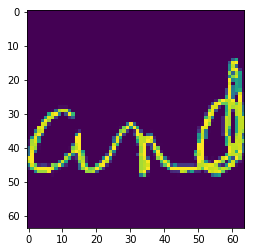

In [137]:
plt.imshow(test[0][7,:,:,0])
plt.show()

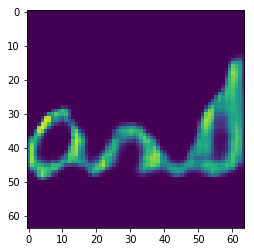

In [138]:
plt.imshow(test2[0,:,:,0])
plt.show()